# get gain/loss M/H

In [7]:
%%bash
dirPATH=${HOME}/CHMsInOtherContexts/CellStateTransition

intersect_features_200bpBin(){
    name=${1} # Spermatogenesis
    CHM_PATH=${2} # ${dirPATH}/Spermatogenesis_GSE137744/CHMs
    CHM_BIN=${3} # 200bp
    CHM_STAGE=${4} # "US DS PS RS"
    C_class=${5} # CHM CHnonM CMnonH
    outdir=${6} # ${dirPATH}/Spermatogenesis_GSE137744/CHMs/CHM_HM_gainLoss
    
    mkdir -p ${outdir}
    cd ${outdir}
    
    cat /mnt/Storage/home/yanghui/annotations/mm10/Bins/mm10.b200bp.euchr.CpGnumber | awk 'BEGIN{FS=OFS="\t"} $4>6{print}' > ${outdir}/temp.bed
    
    for stage in ${CHM_STAGE}; do
        bedtools intersect -a ${outdir}/temp.bed -b ${CHM_PATH}/CHMs/${stage}_${CHM_BIN}.${C_class}.bed -c > ${outdir}/temp2.bed
        mv ${outdir}/temp2.bed ${outdir}/temp.bed
    done    
    mv ${outdir}/temp.bed ${outdir}/${name}_${CHM_BIN}.${C_class}.bed
}

intersect_features_200bpBin PGCsDevelopment ${dirPATH}/PGCsDevelopment 200bp "E10.5 E13.5_female E13.5_male" CHM ${dirPATH}/PGCsDevelopment/CHMs/CHM_HM_gainLoss
intersect_features_200bpBin PGCsDevelopment ${dirPATH}/PGCsDevelopment 200bp "E10.5 E13.5_female E13.5_male" CHnonM ${dirPATH}/PGCsDevelopment/CHMs/CHM_HM_gainLoss
intersect_features_200bpBin PGCsDevelopment ${dirPATH}/PGCsDevelopment 200bp "E10.5 E13.5_female E13.5_male" CMnonH ${dirPATH}/PGCsDevelopment/CHMs/CHM_HM_gainLoss


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition')

In [3]:
stage_dict = {
    'EarlyEmbryogenesis': ['2cell','8cell','Morula','ICM',],
    'PGCsDevelopment':    ['E10.5','E13.5_female','E13.5_male',],
    'Spermatogenesis':    ['US','DS','PS','RS',],
    'RetinalDevelopment': ['E14.5','E17.5','P0','P3','P7','P10','P14','P21',],
    'HeartDevelopment':   ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0',],
    'LiverDevelopment':   ['E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0']
}

In [4]:
df_max_dict = {}
for name in ['PGCsDevelopment']:
    df_dict = {}
    for i, C_class in enumerate(['CHM', 'CMnonH', 'CHnonM']):
        df = pd.read_csv(f'{name}/CHMs/CHM_HM_gainLoss/{name}_200bp.{C_class}.bed', sep='\t', header=None)
        df.columns = ['chr', 'start', 'end', 'CpGNumber'] + stage_dict[name]
        df_dict[C_class] = df.iloc[:, 4:] * (3-i) # CHM:3, CHnonM:1, CMnonH:2, CnonHM:0 # C:0, H:1, M:2
        df_dict[C_class]['site'] = df['chr'] + ':' + df['start'].astype(str) + '-' + df['end'].astype(str)
    
    df_max = pd.DataFrame(np.maximum.reduce([df_dict['CHM'].values, df_dict['CHnonM'].values, df_dict['CMnonH'].values]), columns=df_dict['CHM'].columns)
    df_max_dict[name] = df_max

In [8]:
df_max_sex_dict = {} 
for sex in ['female', 'male'] :
    df_max_sex_dict[sex] = df_max_dict['PGCsDevelopment'][['E10.5', f'E13.5_{sex}', 'site']].copy()
    

In [9]:
df_max_sex_dict[sex]

,E10.5,E13.5_male,site
0,1,1,chr1:3020800-3021000
1,2,1,chr1:3026800-3027000
2,2,1,chr1:3027000-3027200
3,3,3,chr1:3031400-3031600
4,3,3,chr1:3031600-3031800
...,...,...,...
316958,0,0,chr9:124442600-124442800
316959,0,0,chr9:124475600-124475800
316960,0,0,chr9:124475800-124476000
316961,2,0,chr9:124476600-124476800


In [11]:
def get_gainLoss(row):
    if row[0] == 0 and row[1] == 1 :
        return 'C + H -> CH'
    elif row[0] == 0 and row[1] == 2 :
        return 'C + M -> CM'
    elif row[0] == 0 and row[1] == 3 :
        return 'C + HM -> CHM'
    elif row[0] == 1 and row[1] == 2 :
        return 'CH -> CM'
    elif row[0] == 1 and row[1] == 3 :
        return 'CH + M -> CHM'
    elif row[0] == 2 and row[1] == 3 :
        return 'CM + H -> CHM'
    elif row[0] == 1 and row[1] == 0 :
        return 'CH - H -> C'
    elif row[0] == 2 and row[1] == 0 :
        return 'CM - M -> C'
    elif row[0] == 3 and row[1] == 0 :
        return 'CHM - HM -> C'
    elif row[0] == 2 and row[1] == 1 :
        return 'CM -> CH'
    elif row[0] == 3 and row[1] == 1 :
        return 'CHM - M -> CH'
    elif row[0] == 3 and row[1] == 2 :
        return 'CHM - H -> CM'
    elif row[0] == 1 and row[1] == 1 :
        return 'CHnonM consistent'
    elif row[0] == 2 and row[1] == 2 :
        return 'CMnonH consistent'
    elif row[0] == 3 and row[1] == 3 :
        return 'CHM consistent'
    elif row[0] == 0 and row[1] == 0 :
        return 'CnonHM consistent'
    
name = 'PGCsDevelopment'

for sex in ['female', 'male'] :
    df = df_max_sex_dict[sex].copy()
    df['gainLoss'] = df.apply(get_gainLoss, axis=1)
    df['chr'] = df['site'].str.split(':').str[0]
    df['start'] = df['site'].str.split(':').str[1].str.split('-').str[0].astype(int)
    df['end'] = df['site'].str.split(':').str[1].str.split('-').str[1].astype(int)
    df[['chr', 'start', 'end'] + [f'E13.5_{sex}'] + ['gainLoss']].to_csv(
        f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/{name}/CHMs/CHM_HM_gainLoss/{name}_{sex}_200bp.gainLoss.bed', 
        sep='\t', index=False, header=False
        )


In [12]:
df

,E10.5,E13.5_male,site,gainLoss,chr,start,end
0,1,1,chr1:3020800-3021000,CHnonM consistent,chr1,3020800,3021000
1,2,1,chr1:3026800-3027000,CM -> CH,chr1,3026800,3027000
2,2,1,chr1:3027000-3027200,CM -> CH,chr1,3027000,3027200
3,3,3,chr1:3031400-3031600,CHM consistent,chr1,3031400,3031600
4,3,3,chr1:3031600-3031800,CHM consistent,chr1,3031600,3031800
...,...,...,...,...,...,...,...
316958,0,0,chr9:124442600-124442800,CnonHM consistent,chr9,124442600,124442800
316959,0,0,chr9:124475600-124475800,CnonHM consistent,chr9,124475600,124475800
316960,0,0,chr9:124475800-124476000,CnonHM consistent,chr9,124475800,124476000
316961,2,0,chr9:124476600-124476800,CM - M -> C,chr9,124476600,124476800


# compare with IAPEz-int

In [13]:
%%bash
cd ~/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz/CHM_HM_gainLoss
for name in PGCsDevelopment;do
    for sex in female male;do
        gainLossBed=~/CHMsInOtherContexts/CellStateTransition/${name}/CHMs/CHM_HM_gainLoss/${name}_${sex}_200bp.gainLoss.bed
        bedtools intersect -a ${gainLossBed} -b ../mm10_euch.IAPEz-int.merged.num.bed -wao > ${name}_${sex}_200bp_gainLoss.IAPEz-int.bed
        bedtools intersect -b ${gainLossBed} -a ../mm10_euch.IAPEz-int.merged.num.bed -wao > IAPEz-int.${name}_${sex}_200bp_gainLoss.bed
    done
done

In [2]:
df_IAP_dict = {}
for sex in ['female', 'male'] :
    df1 = pd.read_csv(
        f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/overlap_IAPEz/CHM_HM_gainLoss/IAPEz-int.PGCsDevelopment_{sex}_200bp_gainLoss.bed',
        sep="\t", header=None
    )
    df1['class'] = [x if x != '.' else 'non-overlap' for x in df1.iloc[:,-2]]
    df_IAP_dict[sex] = df1

In [19]:
df1['class'].value_counts()

CHM consistent       9186
CHM - M -> CH        1172
non-overlap           564
CHM - H -> CM         364
CM + H -> CHM         234
CM -> CH              153
CMnonH consistent     136
CHnonM consistent      96
CM - M -> C            35
CnonHM consistent      26
CH + M -> CHM          24
C + H -> CH            21
CHM - HM -> C          16
C + HM -> CHM           8
CH -> CM                3
C + M -> CM             3
CH - H -> C             2
Name: class, dtype: int64

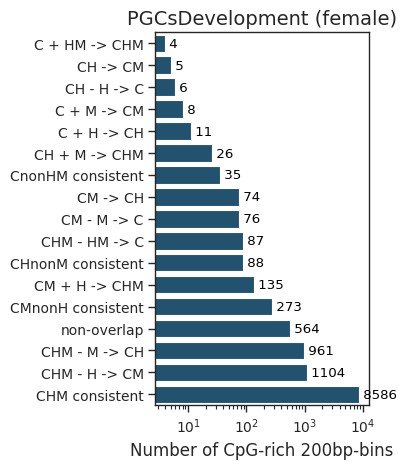

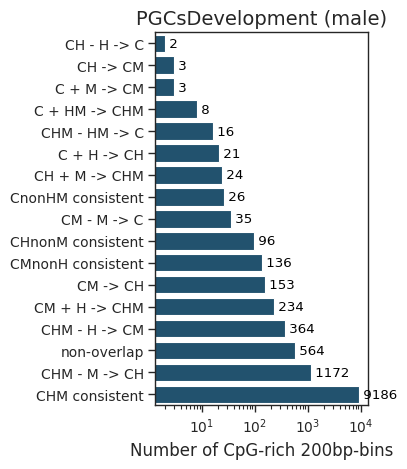

In [10]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    for sex in ['female', 'male'] :
        df1 = df_IAP_dict[sex]
    
        # bar plot for IAPEz-int
        labels = df1['class'].value_counts().index
        sizes = df1['class'].value_counts().values

        # Sort data for better visualization
        sorted_indices = sorted(range(len(sizes)), key=lambda k: sizes[k])
        labels = [labels[i] for i in sorted_indices]
        sizes = [sizes[i] for i in sorted_indices]

        # Plot
        fig, ax = plt.subplots(figsize=(6.4 * .65, 4.8), tight_layout=True)
        sns.barplot(y = labels, x = sizes, palette=["#16557A"], log=True)

        # Add numbers on top of each bar
        for index, value in enumerate(sizes):
            ax.text(value, index, ' ' + str(value), color='black', va="center")
            
        ax.set_xlabel('Number of CpG-rich 200bp-bins')
        # ax.set_title(f'Distribution of IAPEz-int CpG-rich 200bp-bins in PGCsDevelopment ({sex})') 
        ax.set_title(f'PGCsDevelopment ({sex})') 

        fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make5_IAPEzint_PGCsDevelopment_200bp_gainLoss_{sex}.pdf', 
                    transparent=True)


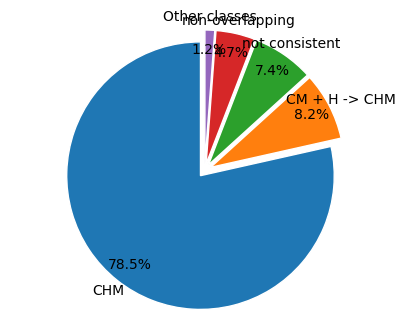

In [110]:
### pie plot for IAPEz-int

import matplotlib.pyplot as plt

# Data
labels = df1[11].value_counts().index
sizes = df1[11].value_counts().values

# Threshold for grouping into 'Other'
threshold = 100
labels = [label for size, label in zip(sizes, labels) if size >= threshold] + ['Other classes']
labels = [x if x != '.' else "non-overlapping" for x in labels]
sizes_other = sum([size for size in sizes if size < threshold])
sizes = [size for size in sizes if size >= threshold] + [sizes_other]

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, 
                                  explode = [0.05] * len(sizes), textprops=dict(color="k", ha="center"),
                                  wedgeprops=dict(width=1, edgecolor='w'), pctdistance=0.85)


# # Draw callout lines
# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# arrowprops = dict(arrowstyle="-", connectionstyle="angle,angleA=0,angleB=90")
# kw = dict(xycoords='data', textcoords='data', arrowprops=arrowprops, bbox=bbox_props, zorder=0, va="center")


# # Rotate labels and set their alignment
# for i, p in enumerate(wedges):
#     ang = (p.theta2 - p.theta1)/2. + p.theta1
#     y = np.sin(np.deg2rad(ang))
#     x = np.cos(np.deg2rad(ang))
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = f"angle,angleA=0,angleB={ang}"
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                  horizontalalignment=horizontalalignment, **kw)

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [93]:
sizes

[9455, 990, 892, 564, 142]

In [91]:
labels

['CHM', 'CM + H -> CHM', 'not consistent', 'non-overlapping', 'Other']